# AKVEG Standardization Notebook
---
---

# Table of contents
1. [PRE-PROCESSING](#preprocess)
    1. [Load fcover data](#loadfcover)
    2. [Join fcover to species checklist table](#joinchecklist)
    3. [Join fcover to leaf retention table](#joinleafretention)
    4. [Export species-PFT tables](#exporthabits)
    5. [Clean exported species-PFT tables](#cleanhabits)
2. [STANDARDIZATION](#standardization)
    1. [Standardize PFT names](#pftnames)
    2. [Sum species fcover to PFT-level](#sumfcover)
    3. [Standardize table layout](#tablelayout)
    4. [Standardize auxiliary columns](#aux)
        1. [Basic plot information](#basics)
        2. [Geographical intersections](#geo)
        3. [Duplicate coordinates](#dupes)
3. [EXPORT](#export)

# Load required packages

In [2]:
import geopandas as gpd
import pandas as pd
import numpy as np
from pyogrio import read_dataframe
import geopandas as gpd
import sys
import os
from urllib.request import urlretrieve
import regex as re
from shapely.validation import make_valid
import importlib
from pathlib import Path

In [3]:
# find helper scripts
project_root = Path.cwd().parent

# 2) Add that root to sys.path
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))
import pavc_funcs.standardize_pft_funcs as spf
importlib.reload(spf)

<module 'pavc_funcs.standardize_pft_funcs' from '/mnt/poseidon/remotesensing/arctic/alaska_pft_fcover_harmonization/pavc_funcs/standardize_pft_funcs.py'>

---
---
# 1. Pre-processing <a name="preprocess"></a>
After visually inspecting each species-level fcover table for obvious errors, we saved the "cleaned" tables to a folder that we then standardized here.

---
## 1.1. Load fcover data <a name="loadfcover"></a>

In [4]:
# throughout the script this will help keep my indices matching
def normalize_to_int_str(val):
    try:
        f = float(val)
        i = int(f)
        if f == i:
            return str(i)
    except (ValueError, TypeError):
        pass
    return str(val)

In [5]:
source = 'akveg'

In [6]:
# read akveg npr-a data, checklist, and ancillary data
fcover_path = f'../data/plot_data/{source}/input_data/{source}_foliar_cover.csv'
fcover = pd.read_csv(fcover_path, index_col=0)
fcover.head(3)

,Project,Site Code,Date,Observer,Recorder,Cover Type,Accepted Name,Cover
ID,,,,,,,,
1,AIM NPR-A,AB-1B,2012-08-01,Tina Boucher,NaN,total cover,Arnica lessingii,0.0
2,AIM NPR-A,AB-1B,2012-08-01,Tina Boucher,NaN,total cover,Artemisia arctica,0.0
3,AIM NPR-A,AB-1B,2012-08-01,Tina Boucher,NaN,total cover,Cardamine bellidifolia,0.0


In [7]:
# 0 means a trace amount was found; convert to 0.05 like "r" in BB
fcover['Cover'].replace(0, 0.05, inplace=True)
fcover['plotVisit'] = fcover['Project'].str.replace(' ', '-') + '_' + fcover['Site Code'].str.replace(' ', '-') + '_' + fcover['Date'].str.replace(' ', '-')
fcover['plotVisit'] = fcover['plotVisit'].apply(normalize_to_int_str)
fcover = fcover[['plotVisit', 'Accepted Name', 'Cover']]

/tmp/ipykernel_852564/1695658011.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  fcover['Cover'].replace(0, 0.05, inplace=True)


In [8]:
len(fcover['plotVisit'].unique())

185

In [9]:
# get unique species names from narrowed down list
u_species_names = fcover['Accepted Name'].unique()
print(len(u_species_names))
species_names_df = pd.DataFrame(u_species_names, columns=['datasetSpeciesName'])

535


---
## 1.2. Join fcover to species checklist table <a name="joinchecklist"></a>

In [10]:
# load species checklist and prep for joining
checklist_path = f'../data/supporting_data/akveg_species_checklist.csv'
checklist_df = spf.checklist_df(checklist_path)
checklist_df.head(3)

,nameCode,checklistSpeciesName,nameStatus,nameAccepted,nameFamily,acceptedNameSource,nameLevel,speciesForm,speciesHabit
0,abroth,Abrothallus De Not.,accepted,Abrothallus De Not.,Abrothallaceae,CNALH,genus,lichen,lichen
1,abrpar,Abrothallus parmeliarum (Sommerf.) Arnold,accepted,Abrothallus parmeliarum (Sommerf.) Arnold,Abrothallaceae,CNALH,species,lichen,lichen
2,abrpey,Abrothallus peyritschii (Stein) Kotte,accepted,Abrothallus peyritschii (Stein) Kotte,Abrothallaceae,Dillman et al. 2012,species,lichen,lichen


In [11]:
species_names_df.head(3)

,datasetSpeciesName
0,Arnica lessingii
1,Artemisia arctica
2,Cardamine bellidifolia


In [12]:
# get first 2 words (genus-species) from checklist accepted name and data species name
checklist_df['joinKey'] = checklist_df['checklistSpeciesName'].apply(spf.get_substrings)
species_names_df['joinKey'] = species_names_df['datasetSpeciesName'].apply(spf.get_substrings)
habits = spf.join_to_checklist(unique_species=species_names_df, 
                               checklist=checklist_df, 
                               u_name='datasetSpeciesName', 
                               c_unofficial_name='checklistSpeciesName', 
                               c_official_name='nameAccepted', 
                               mapping_name='joinKey',
                               habit='speciesHabit')

67 species are missing habits.
62 species still missing habits.
7 species still missing habits.
7 species still missing habits.


In [13]:
habits.head(3)

,datasetSpeciesName,joinKey,speciesHabit
index,,,
0,Arnica lessingii,Arnica lessingii,forb
1,Artemisia arctica,Artemisia arctica,forb
2,Cardamine bellidifolia,Cardamine bellidifolia,forb


In [14]:
species_names_df.head(3)

,datasetSpeciesName,joinKey
0,Arnica lessingii,Arnica lessingii
1,Artemisia arctica,Artemisia arctica
2,Cardamine bellidifolia,Cardamine bellidifolia


In [15]:
habits = species_names_df.merge(habits, how='left', left_on='datasetSpeciesName', right_on='datasetSpeciesName', suffixes=(None, '_1'))
habits = habits[['joinKey', 'datasetSpeciesName', 'speciesHabit']]

---
## 1.3. Join fcover to leaf retention table <a name="joinleafretention"></a>

In [16]:
leaf_df = spf.leaf_retention_df('../data/supporting_data/macander_leaf_retention.csv')
leaf_df.head(3)

,leafRetention,retentionSpeciesName
0,deciduous,Salix
1,deciduous,Betula nana
2,deciduous,Vaccinium uliginosum


In [17]:
# add leaf retention column
habits_wleaf = spf.add_leaf_retention(habits, leaf_df, 'leafRetention')
habits_wleaf = habits_wleaf[['datasetSpeciesName', 'joinKey', 'speciesHabit', 'leafRetention']]
habits_wleaf.head(3)

,datasetSpeciesName,joinKey,speciesHabit,leafRetention
0,Arnica lessingii,Arnica lessingii,forb,
1,Artemisia arctica,Artemisia arctica,forb,
2,Cardamine bellidifolia,Cardamine bellidifolia,forb,


In [18]:
# apply function to remove any extra words with shrub
habits_wleaf['speciesHabit'] = habits_wleaf['speciesHabit'].apply(spf.clean_shrub_habits)
list(habits_wleaf['speciesHabit'].unique())

['forb',
 'graminoid',
 'shrub',
 'spore-bearing',
 'lichen',
 'moss',
 'liverwort',
 nan]

---
## 1.4. Export species-PFT tables <a name="exporthabits"></a>

In [19]:
# generate 3 files and dataframe of habit types
shrubs, nonshrubs, null = spf.export_habit_files(habits_wleaf,
                                                 f'../data/plot_data/{source}/temp_data', 
                                                 source, 
                                                 'speciesHabit')

In [20]:
# check to make sure the files make sense
len(habits_wleaf) == (len(null) + len(nonshrubs) + len(shrubs))

True

---
## 1.5. Clean exported species-PFT tables <a name="cleanhabits"></a>
Here, we manually assessed each file. The nonshrubs were usually correct and did not have to be adjusted. Some shrubs were missing leaf retention information, so we consulted with arctic ecologists to determine it. For unknown (null) habits, we consulted arctic ecology expert, Amy Breen, to determine the issue and correct habit. After the tables were complete, all species names had a single associated habit.
- null habits
    - assign missing habits and consult ecologist when needed
- non-shrubs
    - assign leaf habit to all trees (ctrl-f to find all trees in excel)
        - coniferous tree = evergreen
        - deciduous tree  = deciduous
    - remove leaf habit if misapplied
- shrubs
    - check current leaf habits and correct if necessary
    - fill empty leaf habits
    - choose leaf habit if both evergreen & deciduous listed
    - add Stature column (dwarf shrub or not)

---
---
# 2. Standardization <a name="standardization"></a>

---
## 2.1. Standardize PFT names <a name="pftnames"></a>
deciduous shrub, evergreen shrub, graminoid, forb, litter, non-vascular (lichen, brophyte)

In [21]:
# paths to visually assessed and cleaned habit files
all_habit_types = [f'../data/plot_data/{source}/temp_data/{source}_nonshrubs_01.csv',
                   f'../data/plot_data/{source}/temp_data/{source}_shrubs_01.csv',
                   f'../data/plot_data/{source}/temp_data/{source}_nullhabit_01.csv']

# create list of habit dataframes
habit_dfs = []
for path in all_habit_types:
    habit_df = pd.read_csv(path, index_col=0)
    habit_dfs.append(habit_df)
all_habits = pd.concat(habit_dfs)

In [22]:
# show unique habit names we're working with
all_habits['speciesHabit'].unique().tolist()

['forb',
 'graminoid',
 'spore-bearing',
 'lichen',
 'moss',
 'liverwort',
 'shrub',
 'algae',
 'fungus']

In [23]:
# akveg-specific habit name standardization function
def standardize_habit(habitrow, leafrow):
    
    habitrow = habitrow.to_numpy()
    leafrow = leafrow.to_numpy()
    new_row = []
    
    for habit, leaf in zip(habitrow, leafrow):
        
        habit = habit.lower()
        # non-shrubs
        if 'algae' in habit or 'fungus' in habit:
            new_habit = 'other'
        elif 'moss' in habit or 'liverwort' in habit:
            new_habit = 'bryophyte'
        elif 'spore-bearing' in habit:
            new_habit = 'forb'
            
        # shrubs and trees
        elif 'shrub' in habit:
            new_habit = f'{leaf} shrub'
            
        else:
            new_habit = f'{habit}'
        new_row.append(new_habit)
    
    return new_row

In [24]:
# standardized PFT
standard_habit_col = standardize_habit(all_habits['speciesHabit'], 
                                       all_habits['leafRetention'])
all_habits['standardHabit'] = standard_habit_col
all_habits.rename(columns={'speciesHabit':'nonstandardHabit'}, inplace=True)
print(len(all_habits))
all_habits.head(3)

535


,datasetSpeciesName,joinKey,nonstandardHabit,leafRetention,speciesStature,standardHabit
0,Arnica lessingii,Arnica lessingii,forb,NaN,NaN,forb
1,Artemisia arctica,Artemisia arctica,forb,NaN,NaN,forb
2,Cardamine bellidifolia,Cardamine bellidifolia,forb,NaN,NaN,forb


---
## 2.2. Sum species fcover to PFT-level <a name="sumfcover"></a>

In [25]:
# loop through each plot and sum fcover per pft
all_habits = all_habits[['datasetSpeciesName', 'standardHabit', 'nonstandardHabit']]
species_fcover = fcover.merge(all_habits, 
                               left_on='Accepted Name', 
                               right_on='datasetSpeciesName')
species_fcover = species_fcover.rename(columns={'Cover':'percentCover'})
species_fcover = species_fcover.drop(columns=['Accepted Name'])
species_fcover.head(3)

,plotVisit,percentCover,datasetSpeciesName,standardHabit,nonstandardHabit
0,AIM-NPR-A_AB-1B_2012-08-01,0.05,Arnica lessingii,forb,forb
1,AIM-NPR-A_AB-1B_2012-08-01,0.05,Artemisia arctica,forb,forb
2,AIM-NPR-A_AB-1B_2012-08-01,0.05,Cardamine bellidifolia,forb,forb


In [26]:
len(species_fcover['plotVisit'].unique())

185

In [27]:
species_fcover = species_fcover[['plotVisit', 'datasetSpeciesName', 'standardHabit', 
                                 'nonstandardHabit', 'percentCover']]
species_fcover.head(3)

,plotVisit,datasetSpeciesName,standardHabit,nonstandardHabit,percentCover
0,AIM-NPR-A_AB-1B_2012-08-01,Arnica lessingii,forb,forb,0.05
1,AIM-NPR-A_AB-1B_2012-08-01,Artemisia arctica,forb,forb,0.05
2,AIM-NPR-A_AB-1B_2012-08-01,Cardamine bellidifolia,forb,forb,0.05


In [28]:
# group by 'Site Code' and 'standardHabit', then sum the 'Cover'
temp = species_fcover.groupby(['plotVisit', 'standardHabit'])['percentCover'].sum().reset_index()
pft_fcover = temp.pivot(index='plotVisit', columns='standardHabit', values='percentCover')

In [29]:
# clean up
pft_fcover.columns.name = None
pft_fcover.index.name = 'plotVisit'
pft_fcover.index = pft_fcover.index.map(normalize_to_int_str)
pft_fcover.head(3)

,bryophyte,deciduous shrub,evergreen shrub,forb,graminoid,lichen,other
plotVisit,,,,,,,
AIM-NPR-A_AB-1B_2012-08-01,NaN,0.05,NaN,2.05,1.10,12.7,NaN
AIM-NPR-A_AB-5B_2012-08-01,2.7,14.75,22.0,3.40,7.05,14.1,NaN
AIM-NPR-A_ADST-21_2013-07-30,26.5,19.50,52.6,6.55,6.25,41.3,NaN


In [30]:
len(pft_fcover.index)

185

---
## 2.3. Standardize table layout <a name="tablelayout"></a>

In [31]:
# list of necessary PFTs
pfts = ['deciduous shrub', 'deciduous tree',
        'evergreen shrub', 'evergreen tree',
        'forb', 'graminoid', 'non-vascular',
        'bryophyte', 'lichen', 'litter',
        'bare ground', 'water', 'other']

In [32]:
# load non-vegetation data and format plotVisit
nonveg = pd.read_csv(f'../data/plot_data/{source}/input_data/akveg_nonfoliar_cover.csv')

# 1. Update 'ProjectName' if it contains 'NPR-A'
nonveg['ProjectName'] = nonveg['ProjectName'].apply(
    lambda x: 'AIM-NPR-A' if 'NPR-A' in str(x) else x
)

# 2. Convert 'DateVisited' to YYYY-MM-DD
nonveg['DateVisited'] = pd.to_datetime(nonveg['DateVisited']).dt.strftime('%Y-%m-%d')

# If 'ProjectName' is NaN, set it to 'AIM-NPR-A'
nonveg['ProjectName'] = nonveg['ProjectName'].fillna('AIM-NPR-A')

# Now create 'plotVisit' while ignoring other NaNs
nonveg['plotVisit'] = nonveg[['ProjectName', 'PlotID', 'DateVisited']].apply(
    lambda x: '_'.join(x.dropna().astype(str)), axis=1
)

nonveg['plotVisit'] = nonveg['plotVisit'].apply(normalize_to_int_str)

In [33]:
# The non-veg data is from BLM so there are more non-veg plots than fcover plots
len(nonveg['plotVisit'].unique())

268

In [34]:
nonveg = nonveg[['AH_TotalLitterCover', 'FH_RockCover', 
                 'FH_WaterCover', 'BareSoilCover', 'plotVisit']]
nonveg

,AH_TotalLitterCover,FH_RockCover,FH_WaterCover,BareSoilCover,plotVisit
0,40.816327,0.000000,0.00,0.00,AIM-NPR-A_FMTT-5B_2012-08-03
1,48.000000,0.000000,4.00,0.00,AIM-NPR-A_FWMM-5B_2012-07-31
2,65.333333,0.000000,2.00,0.00,AIM-NPR-A_FWMM-1_2012-07-31
3,22.000000,0.000000,0.00,0.00,AIM-NPR-A_ADST-4_2012-08-01
4,28.000000,2.666667,0.00,0.00,AIM-NPR-A_ADST-1_2012-08-01
...,...,...,...,...,...
263,29.630000,0.000000,10.37,0.00,AIM-NPR-A_CPHCP-78_2017-07-21
264,16.670000,28.670000,0.00,4.67,AIM-NPR-A_ADST-75_2017-07-22
265,37.330000,0.000000,0.00,0.00,AIM-NPR-A_ADST-76_2017-07-22
266,16.000000,28.000000,0.00,0.00,AIM-NPR-A_ADST-79_2017-07-22


In [35]:
nonveg = nonveg.rename(columns=dict(AH_TotalLitterCover='litter',
                                    FH_RockCover='bare ground',
                                    FH_WaterCover='water',
                                    BareSoilCover='bare ground'))
nonveg = nonveg.groupby(nonveg.columns, axis=1).sum()
nonveg = nonveg.set_index('plotVisit')
nonveg.head(3)

/tmp/ipykernel_852564/220112077.py:5: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  nonveg = nonveg.groupby(nonveg.columns, axis=1).sum()


,bare ground,litter,water
plotVisit,,,
AIM-NPR-A_FMTT-5B_2012-08-03,0.0,40.816327,0.0
AIM-NPR-A_FWMM-5B_2012-07-31,0.0,48.000000,4.0
AIM-NPR-A_FWMM-1_2012-07-31,0.0,65.333333,2.0


In [36]:
# add non-vegetation information
pft_fcover = pft_fcover.merge(nonveg,
                              how='left',
                              left_index=True,
                              right_index=True)

In [37]:
pft_fcover

,bryophyte,deciduous shrub,evergreen shrub,forb,graminoid,lichen,other,bare ground,litter,water
plotVisit,,,,,,,,,,
AIM-NPR-A_AB-1B_2012-08-01,NaN,0.05,NaN,2.05,1.10,12.7,NaN,20.666667,0.000000,0.000000
AIM-NPR-A_AB-5B_2012-08-01,2.7,14.75,22.00,3.40,7.05,14.1,NaN,14.000000,16.000000,0.000000
AIM-NPR-A_ADST-21_2013-07-30,26.5,19.50,52.60,6.55,6.25,41.3,NaN,14.666667,44.666667,0.000000
AIM-NPR-A_ADST-2_2012-08-02,2.6,10.05,18.70,5.05,3.60,7.5,NaN,14.000000,10.000000,0.000000
AIM-NPR-A_ADST-33_2013-08-01,8.1,14.70,30.05,28.70,7.70,7.5,NaN,27.333333,21.333333,0.000000
...,...,...,...,...,...,...,...,...,...,...
AIM-NPR-A_TMCW-67_2015-07-30,NaN,NaN,NaN,6.80,58.75,NaN,NaN,46.000000,14.666667,0.000000
AIM-NPR-A_TMCW-68_2015-07-30,21.3,18.05,NaN,2.35,76.05,3.4,NaN,0.666667,64.000000,0.666667
AIM-NPR-A_TMCW-71_2017-07-30,0.7,0.70,NaN,1.40,44.75,NaN,NaN,29.330000,17.330000,23.330000


In [38]:
# create non-vascular
pft_fcover['non-vascular'] = pft_fcover[['bryophyte', 'lichen']].sum(axis=1, skipna=True)

In [39]:
# create standard columns
pft_fcover = spf.add_standard_cols(pft_fcover, pfts)
pft_fcover = pft_fcover[pfts]
pft_fcover.head(3)

,deciduous shrub,deciduous tree,evergreen shrub,evergreen tree,forb,graminoid,non-vascular,bryophyte,lichen,litter,bare ground,water,other
plotVisit,,,,,,,,,,,,,
AIM-NPR-A_AB-1B_2012-08-01,0.05,NaN,NaN,NaN,2.05,1.10,12.7,NaN,12.7,0.000000,20.666667,0.0,NaN
AIM-NPR-A_AB-5B_2012-08-01,14.75,NaN,22.0,NaN,3.40,7.05,16.8,2.7,14.1,16.000000,14.000000,0.0,NaN
AIM-NPR-A_ADST-21_2013-07-30,19.50,NaN,52.6,NaN,6.55,6.25,67.8,26.5,41.3,44.666667,14.666667,0.0,NaN


In [40]:
len(pft_fcover.index.unique())

185

---
## 2.4. Standardize auxiliary columns <a name="aux"></a>

Plot information:
- [ ] UID
- [x] plotName
- [x] dataSource
- [x] dataSubsource
- [x] fcoverScale
- [x] surveyMethod
- [x] surveyPurpose
- [x] duplicatedCoords
- [x] duplicatedDate
- [x] surveyYear
- [x] surveyMonth
- [x] surveyDay

Geographical information:
- [x] bioclimateSubzone
- [x] adminCountry
- [x] adminUnit
- [x] fireYears
- [x] coordEpsg
- [x] georefSource
- [x] georefAccuracy
- [x] plotRadius
- [x] longitueX
- [x] latitudeY

In [41]:
# load auxiliary data from fcover tables
fcover_aux = pd.read_csv(f'../data/plot_data/{source}/input_data/akveg_foliar_cover.csv', index_col=0)
fcover_aux['plotVisit'] = fcover_aux['Project'].str.replace(' ', '-') + '_' + fcover_aux['Site Code'].str.replace(' ', '-') + '_' + fcover_aux['Date'].str.replace(' ', '-')
fcover_aux['plotVisit'] = fcover_aux['plotVisit'].apply(normalize_to_int_str)
fcover_aux['joinKey'] = fcover_aux['Project'].str.replace(' ', '-') + '_' + fcover_aux['Site Code'].str.replace(' ', '-')
fcover_aux = fcover_aux.groupby('plotVisit').first()
fcover_aux.reset_index(inplace=True)

In [42]:
len(fcover_aux['plotVisit'].unique())

185

In [44]:
# load auxiliary data provided by akveg (only has Site Code and Initial Project)
aux = pd.read_csv(f'../data/plot_data/{source}/input_data/akveg_ancillary.csv', index_col=0)
aux['joinKey'] = aux['Initial Project'].str.replace(' ', '-') + '_' + aux['Site Code'].str.replace(' ', '-')

# load sampling methods, coverscale, data source
methods = pd.read_csv('../data/supporting_data/sampling_methods.csv')

In [45]:
# merge aux tables into one
aux = fcover_aux.merge(aux, how='left', 
                       left_on='joinKey', 
                       right_on='joinKey')

In [46]:
aux.columns

Index(['plotVisit', 'Project', 'Site Code_x', 'Date', 'Observer', 'Recorder',
       'Cover Type', 'Accepted Name', 'Cover', 'joinKey', 'Site Code_y',
       'Initial Project', 'Perspective', 'Cover Method', 'Scope Vascular',
       'Scope Bryophyte', 'Scope Lichen', 'Plot Dimensions', 'Datum',
       'Latitude', 'Longitude', 'Uncertainty'],
      dtype='object')

### 2.4.1. Basic plot information <a name="basics"></a>

In [47]:
new_aux = pd.DataFrame()

# date columns
aux['Date'] = (aux['Date'].fillna(-1)).astype(str)
aux['surveyDate'] = pd.to_datetime(aux['Date'], format='mixed', errors='coerce') # convert -1 to NaT
new_aux['surveyYear'] = aux['surveyDate'].dt.year.astype(int)
new_aux['surveyMonth'] = aux['surveyDate'].dt.month.astype(int)
new_aux['surveyDay'] = aux['surveyDate'].dt.day.astype(int)

# plot size
new_aux['plotArea'] = aux['Plot Dimensions']

# Extract plot shape and calculate plot size
def process_plot_dimensions(dimension):
    if 'radius' in dimension:
        # Extract radius and calculate area of the circle
        try:
            radius = float(dimension.split(' radius')[0].strip())
            area = np.pi * (radius**2)
            return {'plotShape': 'circle', 'plotArea': area}
        except ValueError:
            return {'plotShape': 'unknown', 'plotArea': np.NaN}
    elif 'x' in dimension:
        # Extract dimensions and calculate rectangular or square area
        try:
            dimensions = dimension.split('x')
            length = float(dimensions[0].strip())
            width = float(dimensions[1].strip())
            area = length * width
            shape = 'square' if length == width else 'rectangle'
            return {'plotShape': shape, 'plotArea': area}
        except (ValueError, IndexError):
            return {'plotShape': np.NaN, 'plotArea': np.NaN}
    else:
        # Unknown dimension format
        return {'plotShape': 'unknown', 'plotArea': dimension}

# Apply function and update new_aux
processed_dimensions = aux['Plot Dimensions'].apply(process_plot_dimensions)
new_aux['plotShape'] = processed_dimensions.apply(lambda x: x['plotShape'])
new_aux['plotArea'] = processed_dimensions.apply(lambda x: x['plotArea'])

# geographical information
new_aux['latitudeY'] = aux['Latitude'].astype('Float32')
new_aux['longitudeX'] = aux['Longitude'].astype('Float32')
new_aux['georefSource'] = 'GPS'
new_aux['georefAccuracy'] = aux['Uncertainty'].astype('Float32')
new_aux['coordEPSG'] = 'EPSG:4326' # will need to convert from EPSG:4269

# main
new_aux['plotVisit'] = aux['plotVisit']
new_aux['plotName'] = aux['Site Code_x']
# new_aux['dataSource'] = 'AKVEG'
new_aux['dataSubsource'] = 'AIM NPR-A Nawrocki (pub 2020)'
new_aux = new_aux.merge(methods, how='left', left_on='dataSubsource', right_on='dataSubsource')
new_aux = new_aux.set_index(new_aux['plotVisit'])

### 2.4.2. Geographical intersections <a name="geo"></a>

In [52]:
# set geo info
geo_paths = ['../data/supporting_data/fire/InterAgencyFirePerimeterHistory_All_Years_View.shp']
geo_names = ['fire']
geo_cols = [['FIRE_YEAR', 'geometry']]

In [53]:
# create geospatial information
fcover_and_aux = pft_fcover.merge(new_aux, how='left', left_index=True, right_index=True)
fcover_and_aux.index.name = 'plotVisit'
fcover_and_aux.head(3)

,deciduous shrub,deciduous tree,evergreen shrub,evergreen tree,forb,graminoid,non-vascular,bryophyte,lichen,litter,...,coordEPSG,plotVisit,plotName,dataSubsource,dataSource,dataSourceHtml,dataSubsourceCitation,surveyMethod,fcoverScale,surveyPurpose
plotVisit,,,,,,,,,,,,,,,,,,,,,
AIM-NPR-A_AB-1B_2012-08-01,0.05,NaN,NaN,NaN,2.05,1.10,12.7,NaN,12.7,0.000000,...,EPSG:4326,AIM-NPR-A_AB-1B_2012-08-01,AB-1B,AIM NPR-A Nawrocki (pub 2020),AKVEG,https://akveg.uaa.alaska.edu/query-veg-cover/ ...,"Nawrocki, T.W., Carlson, M.L., Osnas, J.L.D., ...",center-staked point-intercept along transect,percent,Quantify spatial patterns and detect changes i...
AIM-NPR-A_AB-5B_2012-08-01,14.75,NaN,22.0,NaN,3.40,7.05,16.8,2.7,14.1,16.000000,...,EPSG:4326,AIM-NPR-A_AB-5B_2012-08-01,AB-5B,AIM NPR-A Nawrocki (pub 2020),AKVEG,https://akveg.uaa.alaska.edu/query-veg-cover/ ...,"Nawrocki, T.W., Carlson, M.L., Osnas, J.L.D., ...",center-staked point-intercept along transect,percent,Quantify spatial patterns and detect changes i...
AIM-NPR-A_ADST-21_2013-07-30,19.50,NaN,52.6,NaN,6.55,6.25,67.8,26.5,41.3,44.666667,...,EPSG:4326,AIM-NPR-A_ADST-21_2013-07-30,ADST-21,AIM NPR-A Nawrocki (pub 2020),AKVEG,https://akveg.uaa.alaska.edu/query-veg-cover/ ...,"Nawrocki, T.W., Carlson, M.L., Osnas, J.L.D., ...",center-staked point-intercept along transect,percent,Quantify spatial patterns and detect changes i...


In [54]:
fcover_and_aux.columns

Index(['deciduous shrub', 'deciduous tree', 'evergreen shrub',
       'evergreen tree', 'forb', 'graminoid', 'non-vascular', 'bryophyte',
       'lichen', 'litter', 'bare ground', 'water', 'other', 'surveyYear',
       'surveyMonth', 'surveyDay', 'plotArea', 'plotShape', 'latitudeY',
       'longitudeX', 'georefSource', 'georefAccuracy', 'coordEPSG',
       'plotVisit', 'plotName', 'dataSubsource', 'dataSource',
       'dataSourceHtml', 'dataSubsourceCitation', 'surveyMethod',
       'fcoverScale', 'surveyPurpose'],
      dtype='object')

In [55]:
# convert to GeoDataFrame
fcover_and_aux = gpd.GeoDataFrame(
    fcover_and_aux,
    geometry=gpd.points_from_xy(fcover_and_aux['longitudeX'], fcover_and_aux['latitudeY']),
    crs='EPSG:4326'
).to_crs('EPSG:5936')

# add geospatial layers
fcover_and_aux = spf.add_geospatial_aux(
    fcover_and_aux,
    paths=geo_paths,
    orig_names=geo_cols
)

Finding spatial intersection for '['FIRE_YEAR', 'geometry']' in native CRS: EPSG:4326


/mnt/poseidon/remotesensing/arctic/alaska_pft_fcover_harmonization/pavc_funcs/standardize_pft_funcs.py:1000: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  grouped = grouped.applymap(normalize_cell)
/mnt/poseidon/remotesensing/arctic/alaska_pft_fcover_harmonization/pavc_funcs/standardize_pft_funcs.py:1021: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  merged = merged.applymap(clean_set_cell)


In [56]:
faa_li = len(fcover_and_aux.index)
faa_ui = len(fcover_and_aux.index.unique())
print(f'Number of plot visits in fcover_and_aux: {faa_li}')
print(f'Number of unique plot visits in fcover_and_aux: {faa_ui}')

Number of plot visits in fcover_and_aux: 185
Number of unique plot visits in fcover_and_aux: 185


In [57]:
# rename new columns
fcover_and_aux.rename(columns={'FIRE_YEAR':'fireYears'}, inplace=True)

### 2.4.3. Duplicate coordinates <a name="dupes"></a>
This indicates that plots may have been revisited, they were very close and GPS accuracy was too low, or there is human error

In [58]:
# find duplicates
fcover_and_aux = spf.find_duplicates(fcover_and_aux, ['longitudeX', 'latitudeY'], 'duplicatedCoords')
fcover_and_aux = spf.find_duplicates(fcover_and_aux, ['surveyYear', 'surveyMonth', 'surveyDay'], 'duplicatedDate')

/mnt/poseidon/remotesensing/arctic/alaska_pft_fcover_harmonization/pavc_funcs/standardize_pft_funcs.py:1051: FutureWarning: DataFrameGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  group_ids = df.groupby(subset, sort=False).grouper.group_info[0]
/mnt/poseidon/remotesensing/arctic/alaska_pft_fcover_harmonization/pavc_funcs/standardize_pft_funcs.py:1051: FutureWarning: DataFrameGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  group_ids = df.groupby(subset, sort=False).grouper.group_info[0]


---
# 3. Export <a name="export"></a>

In [59]:
# clean up
pfts = {'deciduous shrub':'deciduousShrubCover',
        'evergreen shrub':'evergreenShrubCover',
        'deciduous tree':'deciduousTreeCover',
        'evergreen tree':'evergreenTreeCover',
        'forb':'forbCover',
        'graminoid':'graminoidCover',
        'non-vascular':'nonvascularSumCover',
        'bryophyte':'bryophyteCover',
        'lichen':'lichenCover',
        'litter':'litterCover',
        'bare ground':'baregroundCover',
        'water':'waterCover',
        'other':'otherCover'}

# rename columns
fcover_and_aux.rename(columns=pfts, inplace=True)
fcover_cols = list(pfts.values())

# reproject and set cover data type
fcover_and_aux[fcover_cols] = fcover_and_aux[fcover_cols].astype(np.float32)
fcover_and_aux.index.name = 'plotVisit'

In [60]:
fcover_and_aux.columns

Index(['deciduousShrubCover', 'deciduousTreeCover', 'evergreenShrubCover',
       'evergreenTreeCover', 'forbCover', 'graminoidCover',
       'nonvascularSumCover', 'bryophyteCover', 'lichenCover', 'litterCover',
       'baregroundCover', 'waterCover', 'otherCover', 'surveyYear',
       'surveyMonth', 'surveyDay', 'plotArea', 'plotShape', 'latitudeY',
       'longitudeX', 'georefSource', 'georefAccuracy', 'coordEPSG',
       'plotVisit', 'plotName', 'dataSubsource', 'dataSource',
       'dataSourceHtml', 'dataSubsourceCitation', 'surveyMethod',
       'fcoverScale', 'surveyPurpose', 'fireYears', 'duplicatedCoords',
       'duplicatedDate'],
      dtype='object')

In [61]:
# create UID mapping to plotVisit
uid_table = pd.DataFrame({'plotVisit': pft_fcover.index})
uid_table = spf.assign_uid_column(uid_table, id_col='plotVisit', uid_col='UID')

# get UIDs from Arctic AK only
path = '../data/supporting_data/tundra_alaska_latlon/tundra_alaska_wgs84.shp'
ak_tundra = gpd.read_file(path)

# clip and select Arctic AK indices
fcover_and_aux = gpd.GeoDataFrame(fcover_and_aux,
                                  geometry=gpd.points_from_xy(fcover_and_aux['longitudeX'],
                                                              fcover_and_aux['latitudeY']),
                                                              crs='epsg:4326')
fcover_and_aux = fcover_and_aux.to_crs(ak_tundra.crs)
fcover_and_aux = fcover_and_aux.clip(ak_tundra)
valid_uids = fcover_and_aux.index
fcover_and_aux.columns

Index(['deciduousShrubCover', 'deciduousTreeCover', 'evergreenShrubCover',
       'evergreenTreeCover', 'forbCover', 'graminoidCover',
       'nonvascularSumCover', 'bryophyteCover', 'lichenCover', 'litterCover',
       'baregroundCover', 'waterCover', 'otherCover', 'surveyYear',
       'surveyMonth', 'surveyDay', 'plotArea', 'plotShape', 'latitudeY',
       'longitudeX', 'georefSource', 'georefAccuracy', 'coordEPSG',
       'plotVisit', 'plotName', 'dataSubsource', 'dataSource',
       'dataSourceHtml', 'dataSubsourceCitation', 'surveyMethod',
       'fcoverScale', 'surveyPurpose', 'fireYears', 'duplicatedCoords',
       'duplicatedDate', 'geometry'],
      dtype='object')

<Axes: >

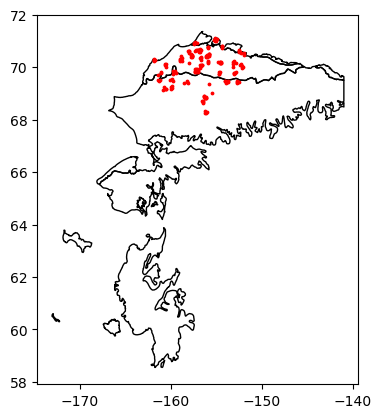

In [62]:
# plot the post-2010 alaskan tundra points
ax = ak_tundra.plot(edgecolor='black', facecolor='none')
fcover_and_aux.plot(ax=ax, color='red', markersize=3)

In [63]:
# remove geometry
fcover_and_aux['geometry'] = fcover_and_aux['geometry'].apply(lambda g: g.wkt if g is not None else None)

/tmp/ipykernel_852564/2164478736.py:2: UserWarning: Geometry column does not contain geometry.
  fcover_and_aux['geometry'] = fcover_and_aux['geometry'].apply(lambda g: g.wkt if g is not None else None)


In [64]:
faa_li = len(fcover_and_aux.index)
faa_ui = len(fcover_and_aux.index.unique())
print(f'Number of plot visits in fcover_and_aux: {faa_li}')
print(f'Number of unique plot visits in fcover_and_aux: {faa_ui}')

Number of plot visits in fcover_and_aux: 184
Number of unique plot visits in fcover_and_aux: 184


In [65]:
# export species fcover
species_fcover_out = species_fcover.copy()
species_fcover_out = species_fcover_out[species_fcover_out['plotVisit'].isin(valid_uids)]
species_fcover_out = spf.replace_column_with_uid(species_fcover_out, uid_table, id_col='plotVisit', uid_col='UID', set_index=False, schema_key='species_fcover')
species_fcover_out = spf.format_column_dtypes(species_fcover_out, schema_key='species_fcover')
spf.export_dataframe(species_fcover_out, f'../data/plot_data/{source}/output_data/{source}_nonstandard_species_fcover.csv', schema_key='species_fcover', index=False)

In [66]:
# export pft fcover
covercols = [col for col in fcover_and_aux.columns if 'Cover' in col]
pft_fcover_out = fcover_and_aux[covercols]
pft_fcover_out = spf.replace_column_with_uid(pft_fcover_out.reset_index(), uid_table, id_col='plotVisit', uid_col='UID', set_index=True, schema_key='pft_fcover')
pft_fcover_out = spf.format_column_dtypes(pft_fcover_out, schema_key='pft_fcover')
spf.export_dataframe(pft_fcover_out, f'../data/plot_data/{source}/output_data/{source}_standard_pft_fcover.csv', schema_key='pft_fcover', index=True)

In [67]:
# export pft aux
auxcols = [col for col in fcover_and_aux.columns if 'Cover' not in col]
pft_aux = fcover_and_aux[auxcols]
pft_aux.drop(columns=['plotVisit'], inplace=True)
pft_aux = spf.replace_column_with_uid(pft_aux.reset_index(), uid_table, id_col='plotVisit', uid_col='UID', set_index=True, schema_key='pft_aux')
pft_aux = spf.format_column_dtypes(pft_aux, schema_key='pft_aux')
spf.export_dataframe(pft_aux, f'../data/plot_data/{source}/output_data/{source}_plot_info.csv', schema_key='pft_aux', index=True)

/tmp/ipykernel_852564/4146134562.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pft_aux.drop(columns=['plotVisit'], inplace=True)
